In [1]:
%matplotlib inline

import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-whitegrid')

In [2]:
def summarize(alpha=0.05):

    def _summarize(ser):
        hpd_ = pm.hpd(ser, alpha=alpha)
        return pd.Series({
            'mean_': ser.mean(),
            'lower': hpd_[0],
            'upper': hpd_[1],
        })

    return _summarize


def agg_prediction(trace_var, source_data, group_columns, aggregate_fc):
    df = pd.DataFrame(trace_var).stack().reset_index()
    merged = pd.merge(
        df, source_data,
        left_on='level_1', right_index=True
    )

    return (
        merged.groupby(group_columns)[0].apply(aggregate_fc)
        .unstack().sort_index().reset_index()
    )


**H6** The data in `Fish` are records of visits to a national park. 

- `fish_caught` : Number of fish caught during visit
- `livebait` : Whether or not group used livebait to fish
- `camper` : Whether or not group had a camper
- `persons` : Number of adults in group
- `child` : Number of children in group
- `hours` : Number of hours group spent in park

The question of interest is how many fish an average visitor takes per hour, when fishing. The problem is that not everyone tried to fish, so the `fish_caught` numbers are zero-inflated. As with the monks example in the chapter, there is a process that determines who is fishing (working) and another process that determines fish per hour (manuscripts per day), conditional on fishing (working). We want to model both. Otherwise we’ll end up with an underestimate of rate of fish extraction from the park. You will model these data using zero-inflated Poisson GLMs.

Predict `fish_caught` as a function of any of the other variables you think are relevant. One thing you must do, however, is use a proper Poisson offset/exposure in the Poisson portion of the zero-inflated model: 
$\mu_i =  \tau_i ~\alpha~ e^{ ~\beta x_i }$.
Then use the `hours` variable to construct the offset. This will adjust the model for the differing amount of time individuals spent in the park.


In [3]:
data = pd.read_csv('../data/Fish.csv', sep=';')
data.sample(5)

,fish_caught,livebait,camper,persons,child,hours
87,1,1,1,1,0,9.611
80,3,1,1,4,1,0.664
236,2,1,1,2,0,2.583
60,2,1,0,2,0,2.955
50,1,1,1,2,1,1.329


In [5]:
with pm.Model() as m_basic:
    base_rate = data.fish_caught.sum() / data.hours.sum()
    alpha = pm.Exponential('alpha', lam=1/base_rate)

    logit_psi = pm.Normal('logit_psi', mu=0, sd=1.5)
    psi = pm.Deterministic('psi', pm.math.invlogit(logit_psi)) 

    fish = pm.Deterministic(
        'fish',
        data.hours.values * alpha
    )

    fish_obs = pm.ZeroInflatedPoisson(
        'fish_obs',
        psi = psi,
        theta = fish,
        observed = data.fish_caught.values
    )
    
    m_basic.name = 'basic'
    m_basic.trace = pm.sample(5000, tune=1000, chains=2)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logit_psi, alpha]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:10<00:00, 1180.58draws/s]


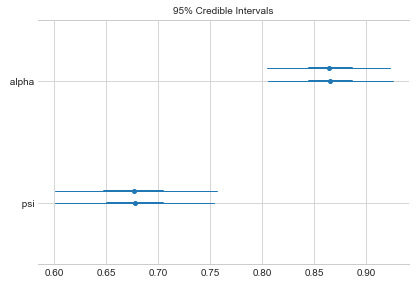

In [6]:
pm.forestplot(m_basic.trace, varnames=['alpha', 'psi'], rhat=False)
None

In [8]:
with pm.Model() as m_bait:
    base_rate = data.fish_caught.sum() / data.hours.sum()

    logit_psi = pm.Normal('logit_psi', mu=0, sd=1.5)
    beta_psi_bait = pm.Normal('beta_psi_bait', mu=0, sd=1)

    alpha = pm.Exponential('alpha', lam=1/base_rate, shape=2)

    psi_i = pm.math.invlogit(
        logit_psi
        + beta_psi_bait * data.livebait.values
    )

    fish = (
        data.hours.values
        * alpha[data.livebait.values]
    )

    fish_obs = pm.ZeroInflatedPoisson(
        'fish_obs',
        psi = psi_i,
        theta = fish,
        observed = data.fish_caught.values
    )
    
    m_bait.name = 'livebait'
    m_bait.trace = pm.sample(5000, tune=1000, chains=2)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta_psi_bait, logit_psi]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:28<00:00, 418.61draws/s]


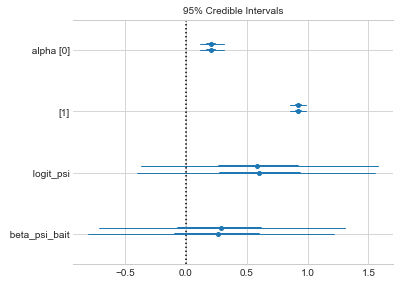

In [9]:
pm.forestplot(m_bait.trace, varnames=['alpha', 'logit_psi', 'beta_psi_bait'], rhat=False)
None

In [12]:
with pm.Model() as m_bait_camper:
    base_rate = data.fish_caught.sum() / data.hours.sum()

    logit_psi = pm.Normal('logit_psi', mu=0, sd=1.5)
    beta_psi_bait = pm.Normal('beta_psi_bait', mu=0, sd=1)
    beta_psi_c = pm.Normal('beta_psi_c', mu=0, sd=1)

    alpha = pm.Exponential('alpha', lam=1/base_rate, shape=2)

    psi_i = pm.math.invlogit(
        logit_psi
        + beta_psi_bait * data.livebait.values
        + beta_psi_c * data.camper.values
    )

    fish = (
        data.hours.values
        * alpha[data.livebait.values]
    )

    fish_obs = pm.ZeroInflatedPoisson(
        'fish_obs',
        psi = psi_i,
        theta = fish,
        observed = data.fish_caught.values
    )
    
    m_bait_camper.name = 'livebait & camper'
    m_bait_camper.trace = pm.sample(5000, tune=2500, chains=2)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta_psi_c, beta_psi_bait, logit_psi]
Sampling 2 chains: 100%|██████████| 15000/15000 [00:41<00:00, 361.52draws/s]


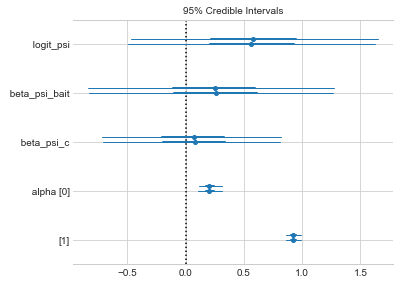

In [13]:
pm.forestplot(m_bait_camper.trace,
              varnames=['logit_psi', 'beta_psi_bait', 'beta_psi_c', 'alpha'],
              rhat=False)
None

In [16]:
with pm.Model() as m_bait_persons:
    base_rate = data.fish_caught.sum() / data.hours.sum()

    logit_psi = pm.Normal('logit_psi', mu=0, sd=1.5)
    beta_psi_bait = pm.Normal('beta_psi_bait', mu=0, sd=1)
    beta_psi_p = pm.Normal('beta_psi_p', mu=0, sd=2)

    alpha = pm.Exponential('alpha', lam=1/base_rate, shape=2)
    beta_fish_p = pm.Normal('beta_fish_p', mu=0, sd=2)

    psi_i = pm.math.invlogit(
        logit_psi
        + beta_psi_bait * data.livebait.values
        + beta_psi_p * data.persons.values
    )

    fish = (
        data.hours.values
        * alpha[data.livebait.values]
        * pm.math.exp(beta_fish_p * data.persons.values)
    )

    fish_obs = pm.ZeroInflatedPoisson(
        'fish_obs',
        psi = psi_i,
        theta = fish,
        observed = data.fish_caught.values
    )
    
    m_bait_persons.name = 'livebait & persons'
    m_bait_persons.trace = pm.sample(5000, tune=2500, chains=2)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_fish_p, alpha, beta_psi_p, beta_psi_bait, logit_psi]
Sampling 2 chains: 100%|██████████| 15000/15000 [01:04<00:00, 234.04draws/s]


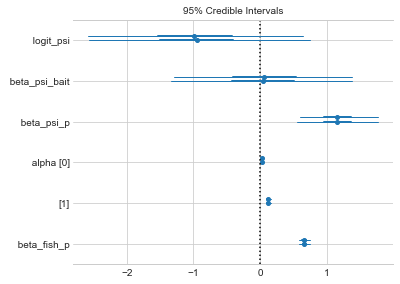

In [17]:
pm.forestplot(m_bait_persons.trace,
              varnames=['logit_psi', 'beta_psi_bait', 'beta_psi_p', 'alpha', 'beta_fish_p'],
              rhat=False)
None

In [18]:
with pm.Model() as m_bait_persons_2:
    base_rate = data.fish_caught.sum() / data.hours.sum()

    logit_psi = pm.Normal('logit_psi', mu=0, sd=1.5)
    beta_psi_multi = pm.Normal('beta_psi_multi', mu=0, sd=1)

    alpha_bait = pm.Exponential('alpha_bait', lam=1/base_rate, shape=2)
    beta_fish_p = pm.Normal('beta_fish_p', mu=0, sd=2)

    psi_i = pm.math.invlogit(
        logit_psi
        + beta_psi_multi * (data.persons.values > 1).astype('int')
    )

    fish = (
        data.hours.values
        * alpha_bait[data.livebait.values]
        * pm.math.exp(beta_fish_p * data.persons.values)
    )

    fish_obs = pm.ZeroInflatedPoisson(
        'fish_obs',
        psi = psi_i,
        theta = fish,
        observed = data.fish_caught.values
    )
    
    m_bait_persons_2.name = 'livebait & persons, v2'
    m_bait_persons_2.trace = pm.sample(5000, tune=1000, chains=2)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_fish_p, alpha_bait, beta_psi_multi, logit_psi]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:49<00:00, 242.51draws/s]


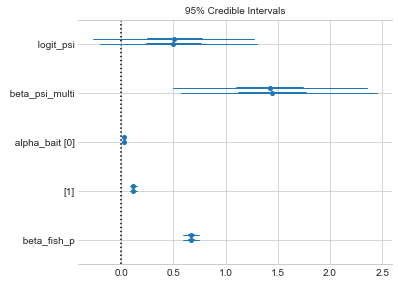

In [19]:
pm.forestplot(m_bait_persons_2.trace,
              varnames=['logit_psi', 'beta_psi_multi', 'alpha_bait', 'beta_fish_p'],
              rhat=False)
None

In [20]:
with pm.Model() as m_all:
    base_rate = data.fish_caught.sum() / data.hours.sum()

    logit_psi = pm.Normal('logit_psi', mu=0, sd=1.5)
    beta_psi_multi = pm.Normal('beta_psi_multi', mu=0, sd=1)
    beta_psi_ch = pm.Normal('beta_psi_ch', mu=0, sd=2)

    alpha_bait = pm.Exponential('alpha_bait', lam=1/base_rate, shape=2)
    beta_fish_p = pm.Normal('beta_fish_p', mu=0, sd=2)
    beta_fish_ch = pm.Normal('beta_fish_ch', mu=0, sd=2)

    psi_i = pm.math.invlogit(
        logit_psi
        + beta_psi_multi * (data.persons.values > 1).astype('int')
        + beta_psi_ch * (data.child.values > 0).astype('int')
    )

    fish = (
        data.hours.values
        * alpha_bait[data.livebait.values]
        * pm.math.exp(
            beta_fish_p * data.persons.values
            + beta_fish_ch * data.child.values
        )
    )

    fish_obs = pm.ZeroInflatedPoisson(
        'fish_obs',
        psi = psi_i,
        theta = fish,
        observed = data.fish_caught.values
    )

    m_all.name = 'all'
    m_all.trace = pm.sample(5000, tune=1000, chains=2)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_fish_ch, beta_fish_p, alpha_bait, beta_psi_ch, beta_psi_multi, logit_psi]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:52<00:00, 229.69draws/s]


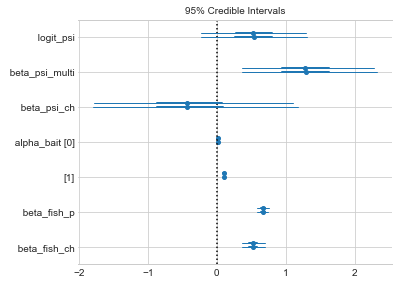

In [22]:
pm.forestplot(m_all.trace,
              varnames=['logit_psi', 'beta_psi_multi', 'beta_psi_ch',
                        'alpha_bait', 'beta_fish_p', 'beta_fish_ch'],
              rhat=False)
None

In [24]:
comparison = pm.compare({
        m_basic: m_basic.trace,
        m_bait: m_bait.trace,
        m_bait_persons_2: m_bait_persons_2.trace,
        m_all: m_all.trace,
        m_bait_camper: m_bait_camper.trace,
        m_bait_persons: m_bait_persons.trace,
    },
    method='BB-pseudo-BMA'
)
comparison

/home/petrushev/etc/jup_env/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/home/petrushev/etc/jup_env/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/home/petrushev/etc/jup_env/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
all,2139.63,92.5,0,0.52,404.3,0,1
livebait & persons,2143.83,76.05,4.2,0.37,407.37,45.5,1
"livebait & persons, v2",2150.41,75.38,10.78,0.09,407.41,47.58,1
livebait,2506.19,47.62,366.56,0.01,470.08,212.94,1
livebait & camper,2506.52,50.21,366.88,0.01,468.77,211.73,1
basic,2562.35,42.24,422.72,0.01,483.78,231.85,1
